# Yield Curve Prediction

The **yield curve** in finance is a graphical representation that shows the relationship between bond yields (interest rates) and their maturities (time to repayment), assuming equal credit quality. It provides valuable insights into market expectations of future interest rates and economic trends.

**Yield Curve Prediction** refers to forecasting the future shape and movements of the yield curve. This is a vital aspect of finance as the yield curve serves as a barometer for economic conditions, interest rate trends, and investor sentiment. Accurate forecasting enables investors, financial institutions, and policymakers to make well-informed decisions about investments, risk management, and monetary policies.

## Problem Statement:
While various mathematical and economic models exist for yield curve prediction, this case focuses on leveraging a supervised machine learning approach to predict its future behavior.

In this case study, we are using a supervised regression model to predict three parts of the yield curve, called tenors:

-   1-month (1M): Short-term.
-   5-year (5Y): Medium-term.
-   30-year (30Y): Long-term.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Loading the Data

**Features**

we need the following features
  - Previous Changes in the Treasury Curve at the following tenors: 1 Month, 3 Month, 1 Year, 2 Year, 5 Year, 7 Year, 10 Year, 30 Year
    
  - Changes in % of Federal Debt held by -

    a. Public,       
    b. Foreign Goverments        
    c. Federal Reserve
    
  - The Coporate Spread on Baa rated Debt Relative to the 10 Year








In [2]:
from pandas_datareader import data as web
start_date = '2010-01-01'



# List of financial indicators to fetch
tickers = [
    'DGS1MO',  # 1-Month Treasury Yield
    'DGS3MO',  # 3-Month Treasury Yield
    'DGS1',    # 1-Year Treasury Yield
    'DGS2',    # 2-Year Treasury Yield
    'DGS5',    # 5-Year Treasury Yield
    'DGS7',    # 7-Year Treasury Yield
    'DGS10',   # 10-Year Treasury Yield
    'DGS30',   # 30-Year Treasury Yield
    'TREAST',  # U.S. Treasury securities held by the Federal Reserve
    'FYGFDPUN',# Federal Debt Held by the Public
    'FDHBFIN', # Federal Debt Held by Foreign and International Investors
    'GFDEBTN', # Total Public Federal Debt
    'BAA10Y',  # Corporate Spread (Baa-rated Corporate Bond Yield vs 10-Year Yield)
]

# Fetch data for these indicators from the FRED database and clean it
data = web.DataReader(tickers, 'fred', start=start_date)  # Fetch the data
data = data.dropna(how='all')           # Remove rows where all values are missing
data = data.ffill()                     # Fill missing values using the previous day's data

# Convert foreign debt data from billions to millions for consistency
data['FDHBFIN'] = data['FDHBFIN'] * 1000

# Calculate percentages of debt held by different groups
data['GOV_PCT'] = data['TREAST'] / data['GFDEBTN']  # Federal Reserve's share of debt
data['HOM_PCT'] = data['FYGFDPUN'] / data['GFDEBTN']  # Public's share of debt
data['FOR_PCT'] = data['FDHBFIN'] / data['GFDEBTN']  # Foreign investors' share of debt

data.head()


,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,TREAST,FYGFDPUN,FDHBFIN,GFDEBTN,BAA10Y,GOV_PCT,HOM_PCT,FOR_PCT
DATE,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8294251.0,3877900.0,12773123.0,NaN,NaN,0.649352,0.303598
2010-01-04,0.05,0.08,0.45,1.09,2.65,3.36,3.85,4.65,NaN,8294251.0,3877900.0,12773123.0,2.54,NaN,0.649352,0.303598
2010-01-05,0.03,0.07,0.41,1.01,2.56,3.28,3.77,4.59,NaN,8294251.0,3877900.0,12773123.0,2.53,NaN,0.649352,0.303598
2010-01-06,0.03,0.06,0.40,1.01,2.60,3.33,3.85,4.70,776595.0,8294251.0,3877900.0,12773123.0,2.49,0.060799,0.649352,0.303598
2010-01-07,0.02,0.05,0.40,1.03,2.62,3.33,3.85,4.69,776595.0,8294251.0,3877900.0,12773123.0,2.48,0.060799,0.649352,0.303598


In [3]:
# Define the prediction period (how many steps ahead we want to predict)
return_period = 5


# This means predicting the future values of 1-month, 5-year, and 30-year yields
Y = data[['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
# Rename the columns to indicate they are predicted values
Y.columns = [col + '_pred' for col in Y.columns]

# Create the input features (X)
X = data[['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
              'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

# Combine predictors (X) and targets (Y) into one dataset
data = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]

# Separate the combined dataset back into predictors (X) and targets (Y)
Y = data[Y.columns]
X = data[X.columns]


In [4]:
data


,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2010-01-06,0.02,2.55,4.71,0.03,0.06,0.40,1.01,2.60,3.33,3.85,4.70,0.060799,0.649352,0.303598,2.49
2010-01-13,0.02,2.38,4.50,0.02,0.06,0.37,0.97,2.55,3.28,3.80,4.71,0.060800,0.649352,0.303598,2.50
2010-01-21,0.01,2.41,4.57,0.02,0.06,0.31,0.87,2.38,3.09,3.62,4.50,0.060800,0.649352,0.303598,2.51
2010-01-28,0.04,2.29,4.53,0.01,0.08,0.31,0.87,2.41,3.15,3.68,4.57,0.060801,0.649352,0.303598,2.57
2010-02-04,0.05,2.39,4.69,0.04,0.09,0.32,0.80,2.29,3.06,3.62,4.53,0.060801,0.649352,0.303598,2.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18,4.89,4.07,4.51,4.92,4.73,4.19,3.95,3.88,3.97,4.08,4.38,0.125104,0.793362,0.235717,1.53
2024-10-25,4.75,4.22,4.57,4.89,4.73,4.29,4.11,4.07,4.15,4.25,4.51,0.125106,0.793362,0.235717,1.51
2024-11-01,4.70,4.20,4.47,4.75,4.61,4.28,4.21,4.22,4.30,4.37,4.57,0.125111,0.793362,0.235717,1.46


## Data Cleaning
- Checking Missing values
- Check data type
- Understand the dataset(Description)


In [5]:
data.shape

(752, 15)

In [6]:
data.columns

Index(['DGS1MO_pred', 'DGS5_pred', 'DGS30_pred', 'DGS1MO', 'DGS3MO', 'DGS1',
       'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT',
       'FOR_PCT', 'BAA10Y'],
      dtype='object')

In [7]:
data.isnull().sum()

,0
DGS1MO_pred,0
DGS5_pred,0
DGS30_pred,0
DGS1MO,0
DGS3MO,0
DGS1,0
DGS2,0
DGS5,0
DGS7,0
DGS10,0


In [8]:
data.duplicated().sum()

0

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
DGS1MO_pred,752.0,1.175013,1.768332,0.000000,0.040000,0.140000,1.782500,5.730000
DGS5_pred,752.0,1.921915,1.118601,0.210000,1.140000,1.660000,2.522500,4.810000
DGS30_pred,752.0,3.128684,0.837332,1.200000,2.617500,3.050000,3.722500,5.040000
DGS1MO,752.0,1.168750,1.764024,0.000000,0.040000,0.140000,1.772500,5.730000
DGS3MO,752.0,1.226144,1.782499,0.000000,0.050000,0.160000,1.922500,5.630000
DGS1,752.0,1.346356,1.669024,0.040000,0.150000,0.395000,2.072500,5.460000
DGS2,752.0,1.461157,1.472314,0.090000,0.337500,0.755000,2.295000,5.090000
DGS5,752.0,1.919827,1.115861,0.210000,1.140000,1.660000,2.522500,4.810000
DGS7,752.0,2.221037,1.001551,0.390000,1.490000,2.065000,2.810000,4.880000
DGS10,752.0,2.484322,0.920793,0.550000,1.820000,2.375000,2.990000,4.880000


- Data has no missing values and duplicates
- All data columns are all numerical
- The data contains outliers as seen by the difference between the max and 75 percentile
- Also in  some columns there is a large variation as seen in the standard deviation column


## Data Visualization

<Axes: xlabel='DATE'>

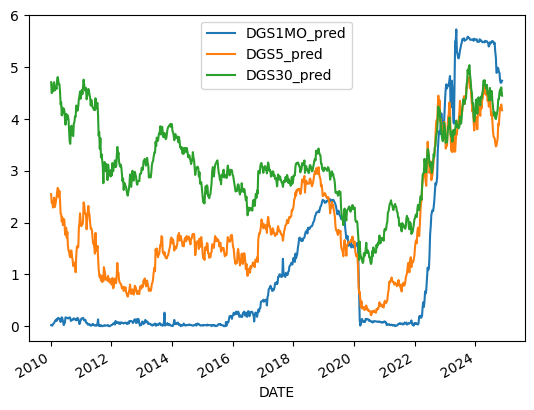

In [10]:
Y.plot()

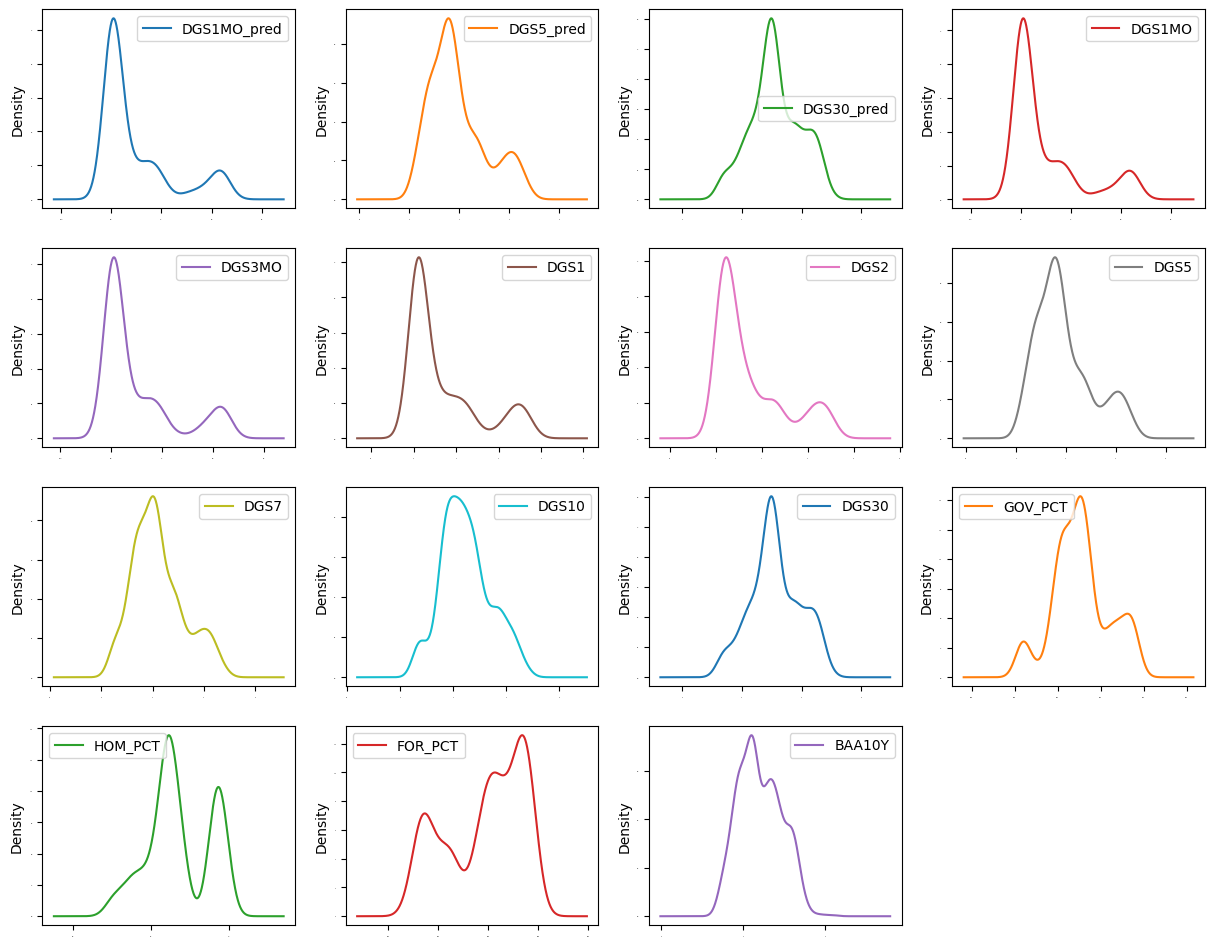

In [11]:
# density
data.plot(kind='density', subplots=True, layout=(5,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
plt.show()

- The density plots for treasury yields (e.g., DGS1MO, DGS5, DGS30) exhibit multimodal distributions, indicating periods of varying interest rate regimes. Debt percentages (GOV_PCT, HOM_PCT, FOR_PCT) show distinct peaks, reflecting stable allocations for different debt holders.
- The distribution of the corporate spread (BAA10Y) is relatively smooth and centered, likely reflecting consistent differences between corporate and treasury yields over time.

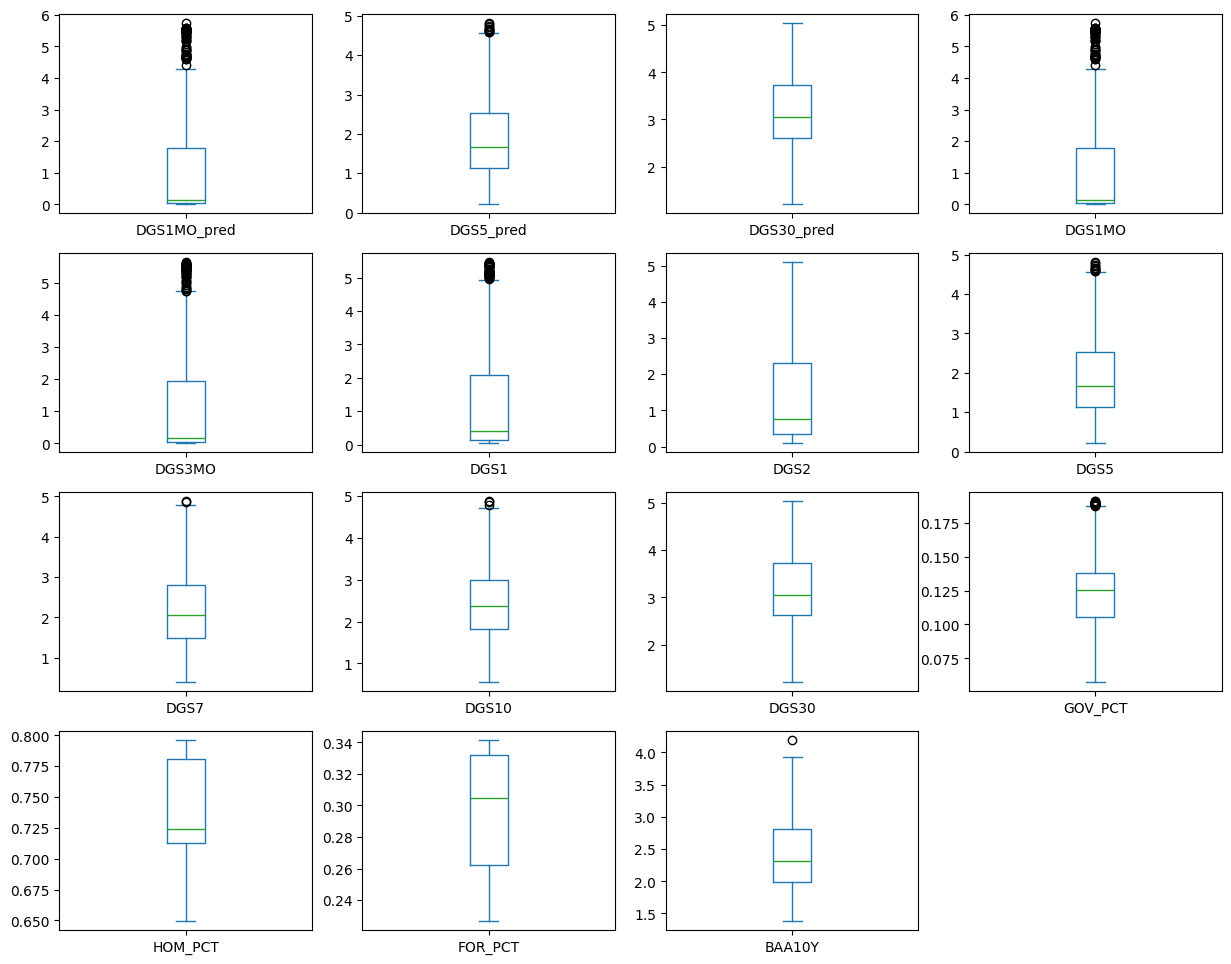

In [12]:
#Box and Whisker Plots
data.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))
plt.show()

- Treasury yields (e.g., DGS1MO, DGS5, DGS30) exhibit significant outliers at higher values, indicating periods of extreme interest rates, with moderate interquartile ranges showing stable trends for most periods.
- he variables GOV_PCT, HOM_PCT, and FOR_PCT have relatively narrower interquartile ranges, suggesting consistent debt allocation proportions over time, with minimal outliers observed.

<Axes: title={'center': 'Correlation Matrix'}>

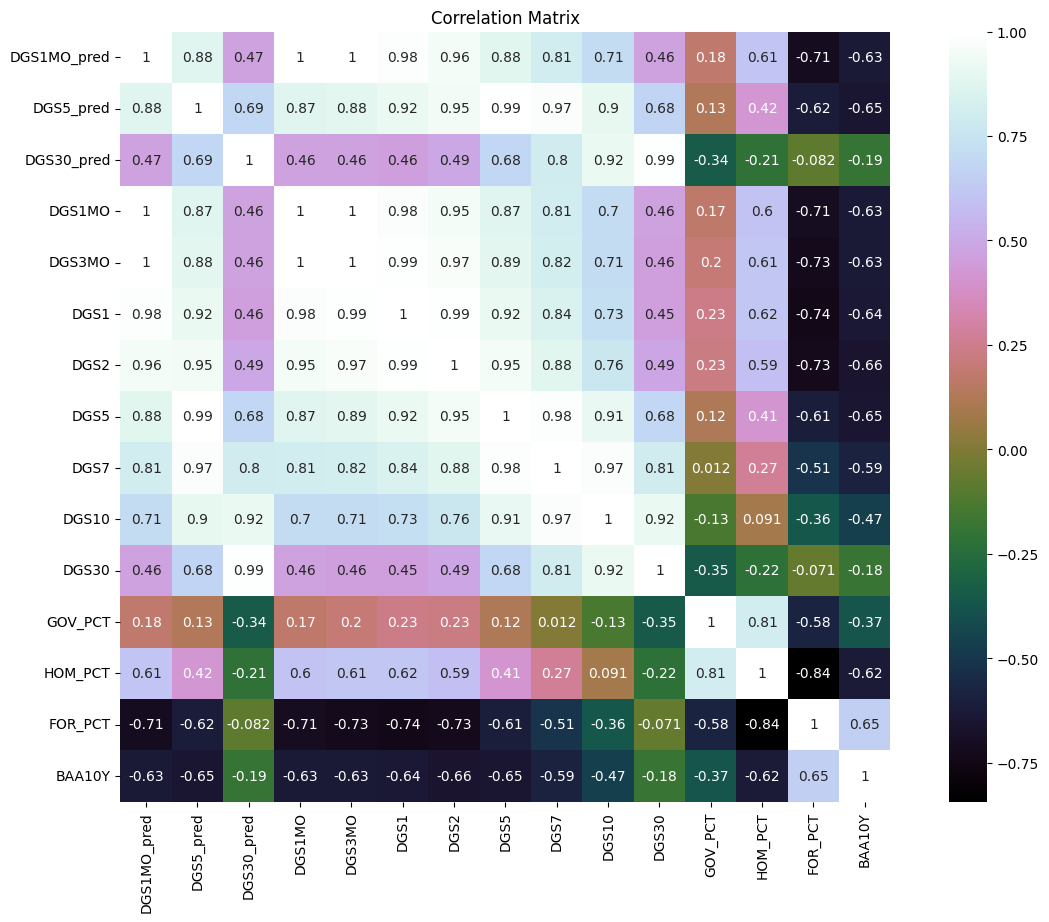

In [13]:
# correlation
correlation = data.corr()
plt.figure(figsize=(15,10))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

- **High Correlations:** Most Treasury yields (e.g., DGS1MO, DGS3MO, DGS1, DGS2) show very high positive correlations with one another, indicating strong co-movements across different maturity periods.

- **Debt Shares and Yields:** FOR_PCT (foreign debt share) and HOM_PCT (public debt share) exhibit negative correlations with Treasury yields, suggesting an inverse relationship between debt distribution and interest rate levels. Conversely, GOV_PCT (Federal Reserve debt share) has weak or minimal correlations with yields.

### Time series decomposition

**1 month**

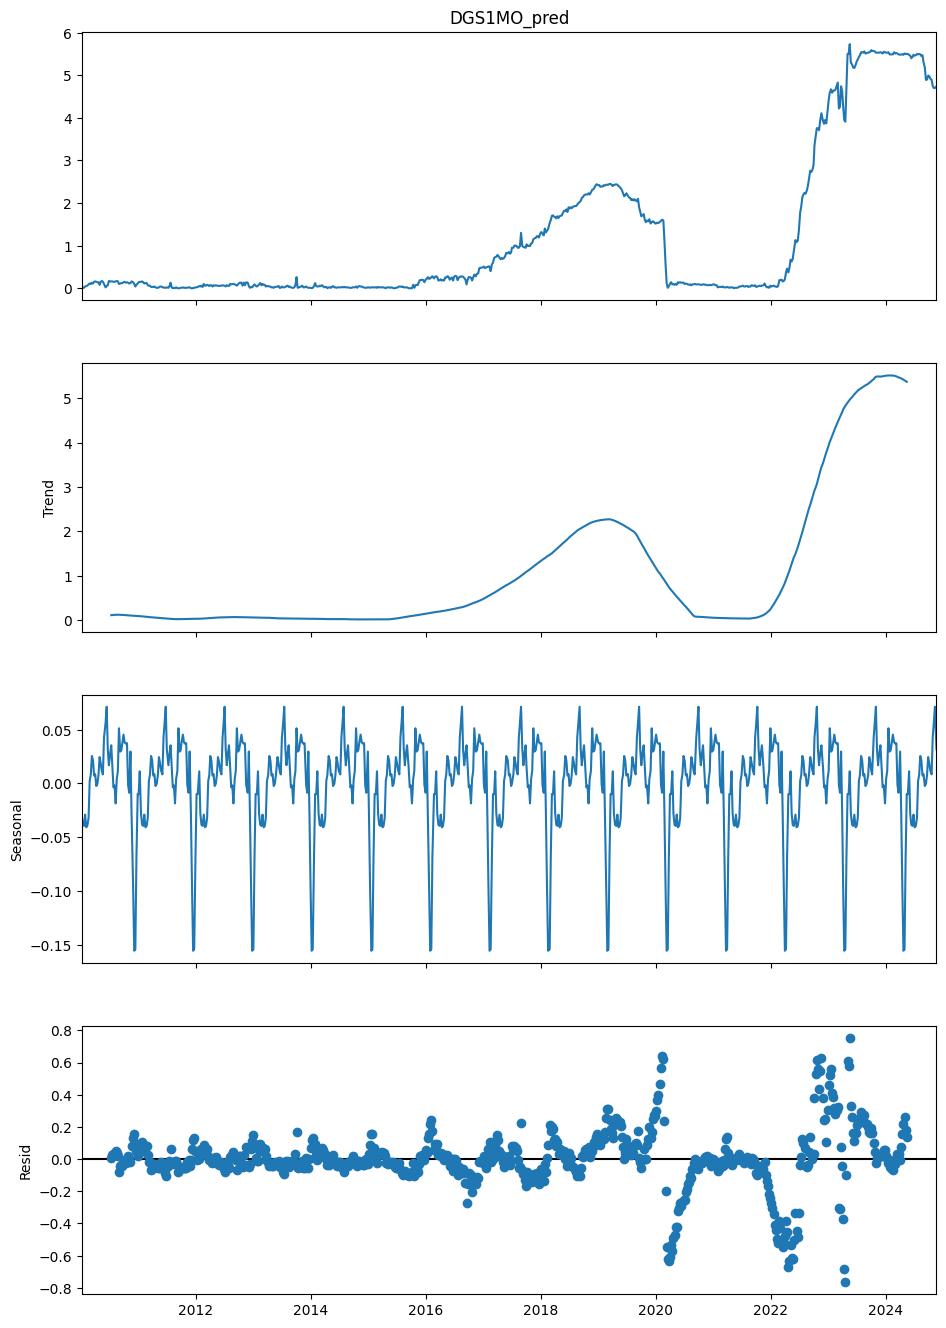

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_1month = data['DGS1MO_pred']
result = seasonal_decompose(decompose_1month, period=52)
fig = result.plot()
fig.set_size_inches(10, 15)
plt.show()



**5 Year**

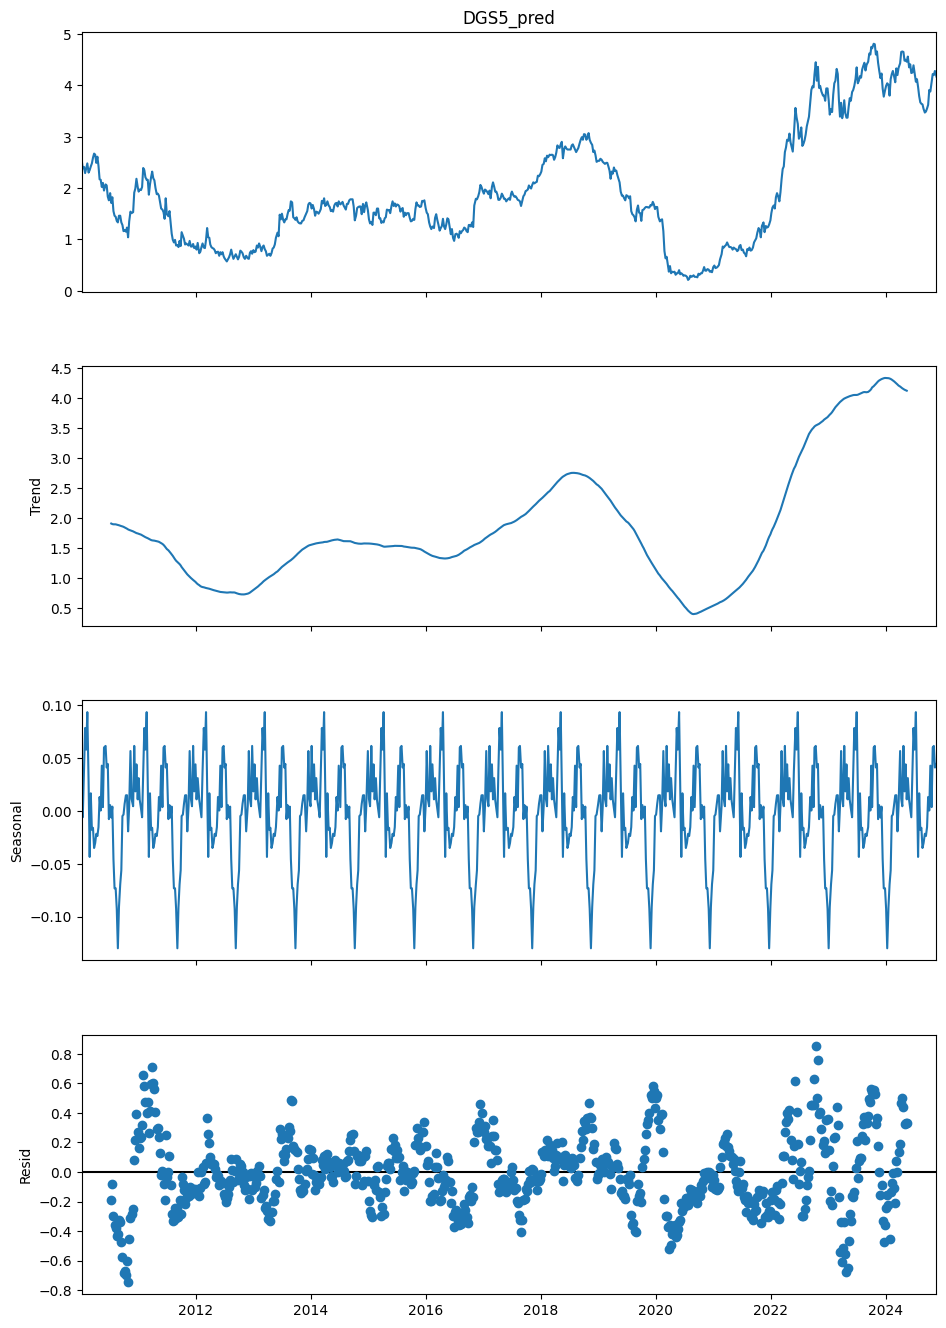

In [15]:
decompose_5year = data['DGS5_pred']
result = seasonal_decompose(decompose_5year, period=52)
fig = result.plot()
fig.set_size_inches(10, 15)
plt.show()

**30 years**


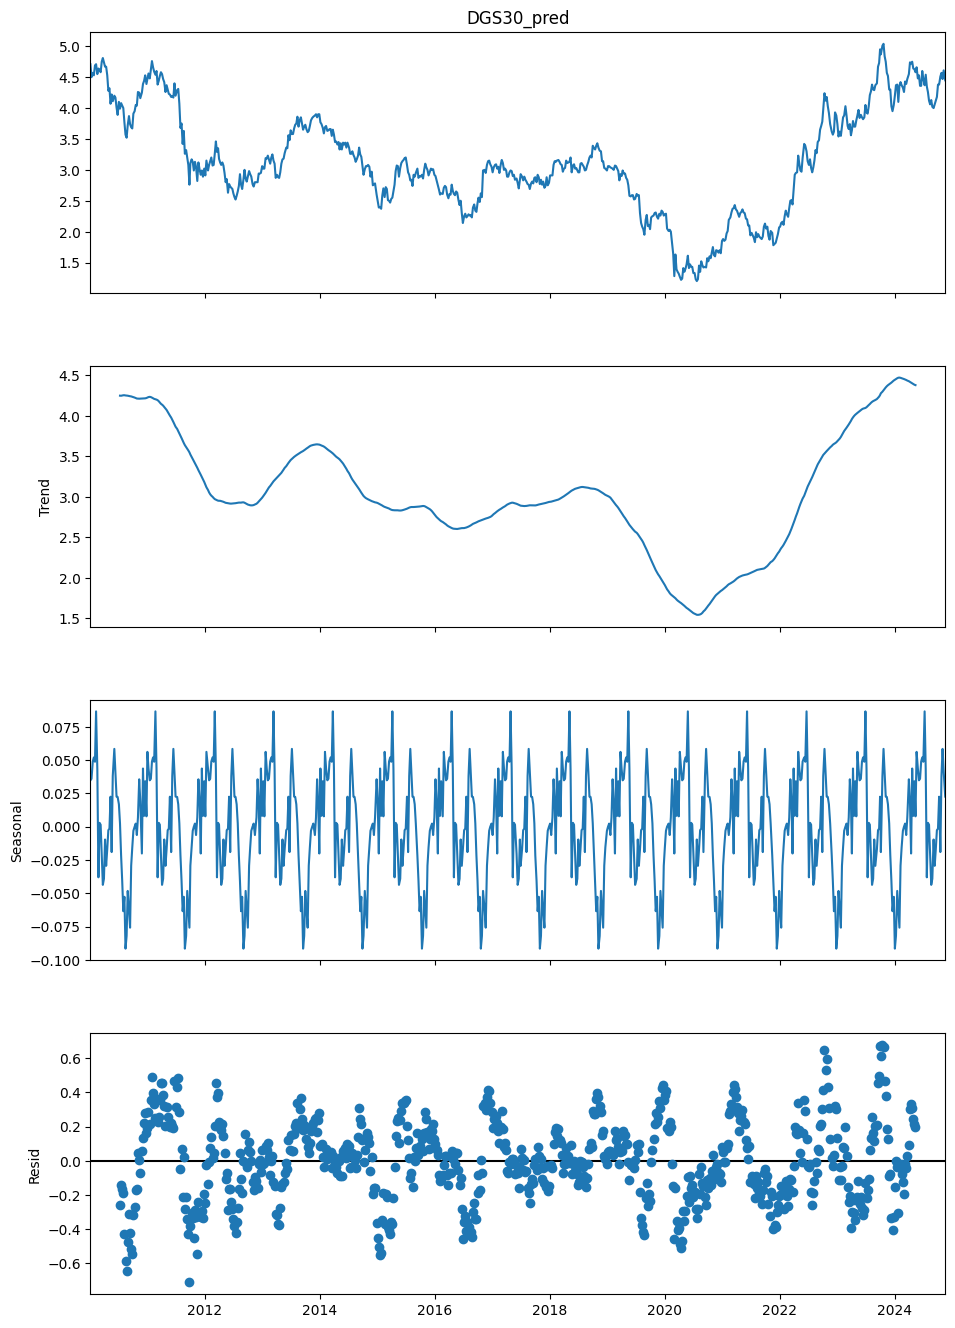

In [16]:
decompose_30year = data['DGS30_pred']
result = seasonal_decompose(decompose_30year, period=52)
fig = result.plot()
fig.set_size_inches(10, 15)
plt.show()

We noticed a sharp decrease  in the 1month,5year and 30year in 2020 which was followed by a rise this might be due to covid or elections in the USA but this is just a guess.

## Evaluate Algorithms and Models

In [17]:
!pip install catboost


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
# splitting the data
validation_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [20]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'

Linear Regression:
Average CV error: 0.010781
Std CV Error: (0.002263)
Training Error:
DGS1MO_pred    0.005715
DGS5_pred      0.013264
DGS30_pred     0.011484
dtype: float64
Test Error:
DGS1MO_pred    0.006203
DGS5_pred      0.012924
DGS30_pred     0.012667
dtype: float64
----------
Lasso:
Average CV error: 0.549009
Std CV Error: (0.132345)
Training Error:
DGS1MO_pred    0.358895
DGS5_pred      0.596203
DGS30_pred     0.665725
dtype: float64
Test Error:
DGS1MO_pred    0.534598
DGS5_pred      0.784598
DGS30_pred     0.837483
dtype: float64
----------
Ridge:
Average CV error: 0.010797
Std CV Error: (0.002215)
Training Error:
DGS1MO_pred    0.005778
DGS5_pred      0.013738
DGS30_pred     0.011585
dtype: float64
Test Error:
DGS1MO_pred    0.006131
DGS5_pred      0.013438
DGS30_pred     0.013261
dtype: float64
----------
MLP Regressor:
Average CV error: 0.015821
Std CV Error: (0.003620)
Training Error:
DGS1MO_pred    0.017704
DGS5_pred      0.026488
DGS30_pred     0.020831
dtype: float64
Te

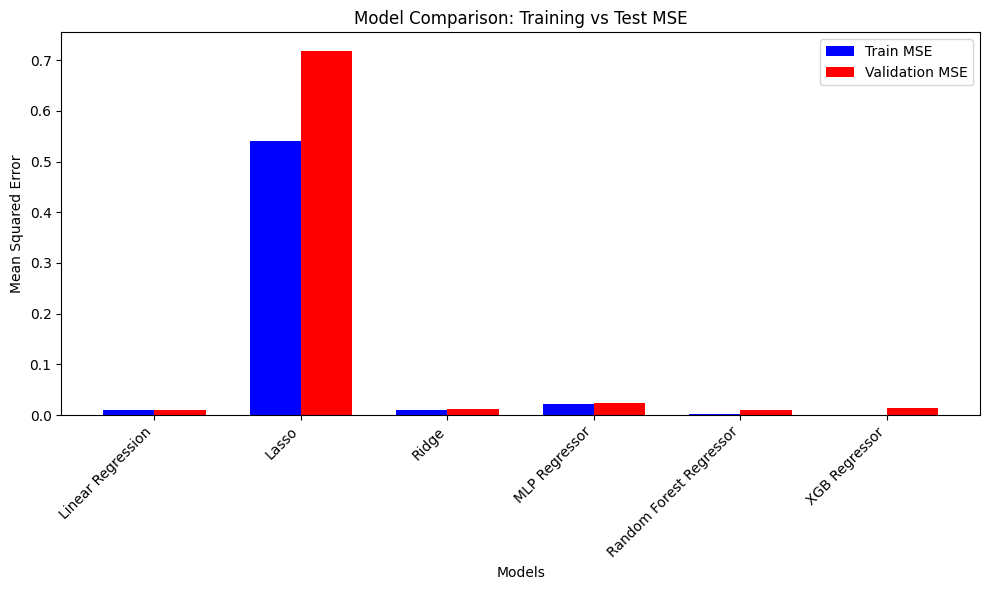

In [21]:

# Dictionary of models (already defined earlier)
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "MLP Regressor": MLPRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGB Regressor": XGBRegressor()
}

# Initialize lists to store metrics
kfold_results = []
names = []
validation_results = []
train_results = []
train_mse_means = []  # To store mean training MSE for each model
validation_mse_means = []  # To store mean test MSE for each model

# Set up k-fold cross-validation
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'  # Using neg_mean_squared_error to align with MSE

# Loop through models
for name, model in models.items():
    # Perform k-fold cross-validation
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)  # Convert to positive MSE
    kfold_results.append(cv_results)
    names.append(name)

    # Train the model on the full training set
    model.fit(X_train, Y_train)

    # Calculate training error (multi-output MSE per column)
    train_pred = model.predict(X_train)
    train_mse = pd.Series(
        [mean_squared_error(Y_train[col], train_pred[:, i]) for i, col in enumerate(Y_train.columns)],
        index=Y_train.columns
    )
    train_results.append(train_mse)
    train_mse_means.append(train_mse.mean())  # Store the mean training MSE

    # Calculate validation error (multi-output MSE per column)
    val_pred = model.predict(X_test)
    validation_mse = pd.Series(
        [mean_squared_error(Y_test[col], val_pred[:, i]) for i, col in enumerate(Y_test.columns)],
        index=Y_test.columns
    )
    validation_results.append(validation_mse)
    validation_mse_means.append(validation_mse.mean())  # Store the mean test MSE

    # Print results for the model
    print(f"{name}:")
    print(f"Average CV error: {cv_results.mean():.6f}")
    print(f"Std CV Error: ({cv_results.std():.6f})")
    print("Training Error:")
    print(train_mse)
    print("Test Error:")
    print(validation_mse)
    print("----------")

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

# Set positions for bars
ind = np.arange(len(names))  # x locations for the groups
width = 0.35  # the width of the bars

# Plotting train and validation MSE as bars
ax.bar(ind - width / 2, train_mse_means, width=width, label='Train MSE', color='b')
ax.bar(ind + width / 2, validation_mse_means, width=width, label='Validation MSE', color='r')

# Set labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Model Comparison: Training vs Test MSE')
ax.set_xticks(ind)
ax.set_xticklabels(names)
ax.legend()

# Display the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()





- Apart from lasso which perfomed poorly compared to the other models the rest showed some promising results.
- We will go with the linear regression and  MLP regressor because they perfomed well on both train and test as the other models showed some overfitting.
- The linear regression model perfomed so good and there is no need to tune it further but we will  tune the MLP.

### Tuning MLP regressor

In [22]:


# Define hyperparameters for grid search
param_grid = {'hidden_layer_sizes': [(20,), (50,), (20, 20), (20, 30, 20)]}

# Initialize MLP Regressor model
model = MLPRegressor()

# Set up k-fold cross-validation
kfold = KFold(n_splits=10)

# Create GridSearchCV object with model, parameters, and cross-validation settings
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)

# Fit the model using the training data
grid_result = grid.fit(X_train, Y_train)

# Print the best result from grid search
print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Print all the results of the grid search
for mean, stdev, param in zip(grid_result.cv_results_['mean_test_score'],
                              grid_result.cv_results_['std_test_score'],
                              grid_result.cv_results_['params']):
    print(f"{mean:.6f} ({stdev:.6f}) with: {param}")


Best score: -0.016865 using {'hidden_layer_sizes': (20, 30, 20)}
-0.033635 (0.011127) with: {'hidden_layer_sizes': (20,)}
-0.018007 (0.004028) with: {'hidden_layer_sizes': (50,)}
-0.021651 (0.010140) with: {'hidden_layer_sizes': (20, 20)}
-0.016865 (0.003144) with: {'hidden_layer_sizes': (20, 30, 20)}


In [23]:
# prepare model
model = MLPRegressor(hidden_layer_sizes= (20, 30, 20))
model.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

### comparing the two models

In [24]:
# estimate accuracy on validation set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predictions = model.predict(X_test)
mse_MLP = mean_squared_error(Y_test, predictions)
r2_MLP = r2_score(Y_test, predictions)

# prepare the regression model
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_test)

mse_OLS = mean_squared_error(Y_test, predictions_2)
r2_OLS = r2_score(Y_test, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP ))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP ))

MSE Regression = 0.010598, MSE MLP = 0.019535
R2 Regression = 0.991709, R2 MLP = 0.985794


### visual comparison of the two models

In [25]:
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (50,))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_test), index=Y_test.index,
                      columns=Y_test.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_test), index=Y_test.index,
                      columns=Y_test.columns)

<Axes: xlabel='DATE'>

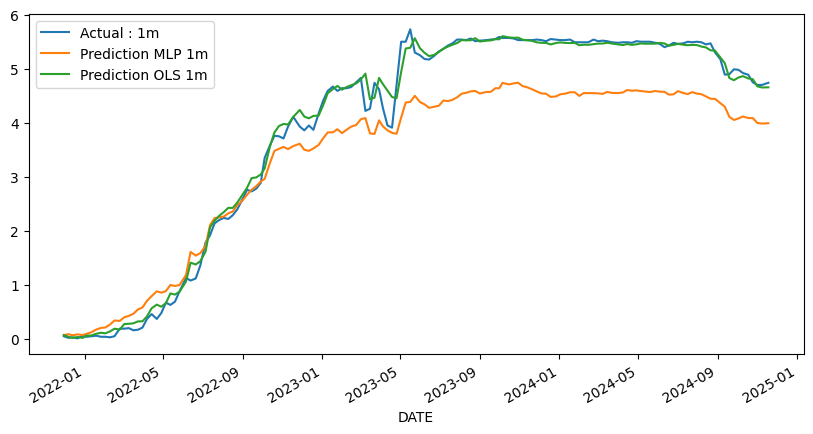

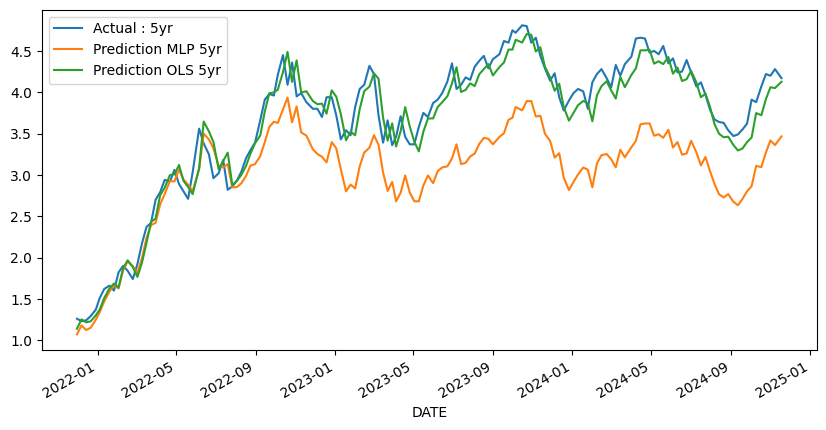

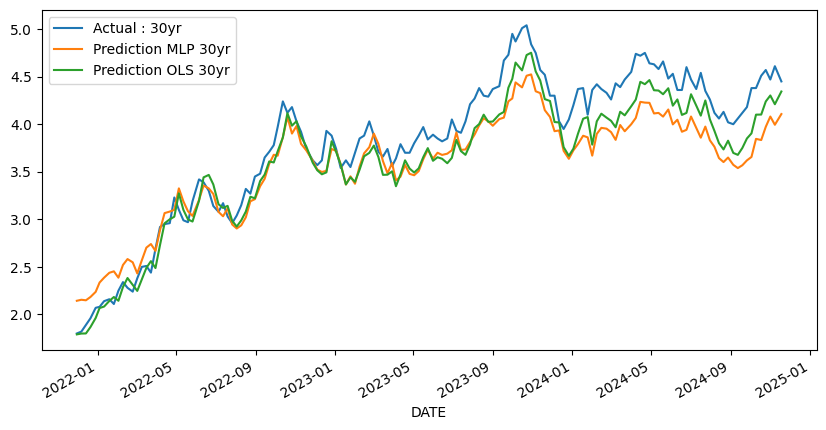

In [26]:
pd.DataFrame({'Actual : 1m': Y_test.loc[:, 'DGS1MO_pred'],
              'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
              'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 5yr': Y_test.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
              'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 30yr': Y_test.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
              'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']}).plot(figsize=(10,5))

- Overall, both the MLP and Linear Regression models performed very well. However, for the 1-month and 5-year predictions, Linear Regression outperformed the MLP model. Conversely, in the 30-year predictions, the MLP model appeared to perform better.

## Summary
The Linear Regression model, despite its simplicity, serves as a strong benchmark for one-step-ahead forecasting due to the significant influence of the most recent value of the variable being predicted. In this case study, the ANN's performance is comparable to that of the Linear Regression model.

One key advantage of ANN is its flexibility in adapting to changing market conditions. Additionally, ANN models can be further improved by conducting a grid search to optimize various hyperparameters or by leveraging advanced architectures like Recurrent Neural Networks (RNNs) or Long Short-Term Memory (LSTM) networks.